# PINN for an Harmonic Oscillator (Direct and Inverse problem)

Based on Lecture 5 AI in the Sciences and Engineering ETH 2024

The problem to solve is the damped harmonic oscilator. A system which after experiencing a certain perturbation experiences a restoring force proportional to this perturbation. It can be seen as mass attached with a spring to a fixed point.

In the direct problemn we are interested in modeling the displacement of the mass on the spring over time when exposed to friction. Meaning how far from the equilibrium is the mass at each time.
The displacement $u(t)$ is described by the equation:

$$ m \frac{d^2 u}{dt^2} + \mu \frac{du}{dt} + ku =0 $$

where $m$ is the mass of the oscillator, $\mu$ is the coefficient of friction and $k$ is the spring constant.

In the underdamped state, the friction is not enoguh to prevent oscillations, but these will gradually decrease over time. This happens when:

$$ \delta < \omega_o \ , where \ \delta = \frac{\mu}{2m},\ \omega_o = \left(\frac{k}{m}\right)^{(1/2)}$$

The following initial condition will be considered:
$$ u(t=0) = 1 , \frac{du}{dt} (t=0)=0$$

The exact solution has analytical form given by:

$$ \mu(t) = e^{-\delta t} (2Acos(\phi + \omega t)), \ with \ \omega = (\omega_o^2 - \delta^2)^{(1/2)}$$

## Direct problem

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
def exact_solution(d,w0,t):
    " analytical soluction for the damped system"
    assert d < w0, "not an underdamped condition" #only for development
    w= np.sqrt(w0**2 - d**2)
    phi= np.arctan(-d/w) # according to ivp
    A= 1/(2* np.cos(phi)) # accordgin to ivp
    cos= torch.cos(phi+w*t)
    exp= torch.exp(-d*t)
    u = exp*2*A*cos
    return u
    
class FCN(nn.Module): # nn.Module to inherit pytorch parameters
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
            nn.Linear(N_INPUT,N_HIDDEN),
            activation()          
        ]) #input layer as an unpacked list
        self.fch = nn.Sequential(*[
                                nn.Sequential(*[
                                    nn.Linear(N_HIDDEN, N_HIDDEN),activation()                                   
                                ]) for _ in range (N_LAYERS-1)
                                ]) # as many hidden layers as the model is built for
        self.fce = nn.Linear(N_HIDDEN,N_OUTPUT) #output layer as unpacked list
    def forward (self,x):
        #Passing input trough every layer
        x= self.fcs(x)
        x= self.fch(x)
        x= self.fce(x)
        return x
        

We will simulate the system to have a set of reference points. Then the neural network will work as a surrogate model $NN(t;\theta) \approx u(t) $ For this instance we use $\delta = 2, \omega_o =20, m=1$ over the domain $t=[0,1]$.

The differential equation and initial conditions are introduced in the loss function which will be:

$$\mathcal{L}(\theta)=(N N(0 ; \theta)-1)^2+\lambda_1\left(\frac{d N N}{d t}(0 ; \theta)-0\right)^2+\frac{\lambda_2}{N} \sum_i^N\left(\left[m \frac{d^2}{d t^2}+\mu \frac{d}{d t}+k\right] N N\left(t_i ; \theta\right)\right)^2 $$

The first and second term represent the initial conditions, on the solution surrogate $ u(t)$ and its derivative. The first term doesnt include a regularization term, or can be interpreted as 1. The third term represents the differential equation, along a regularization term, and is dependent on the number of collocation points.

To compute the gradients for the training section we will use torch.autograd.grad. This function computes and returns the sum of gradients of outputs with respect to the inputs. A sum of how much does the output changes with respect of the input.

grad_outputs should be a sequence of length matching output and containing the "vector" in vector-Jacobian product. Usually the pre-computed gradientes w.r.t. each of the outputs. If an output doesnt require_grad, then the gradiente can be None.


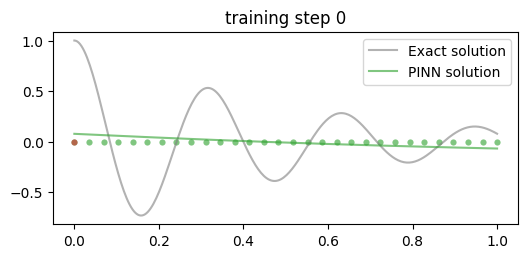

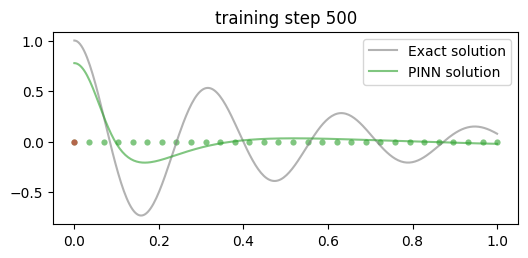

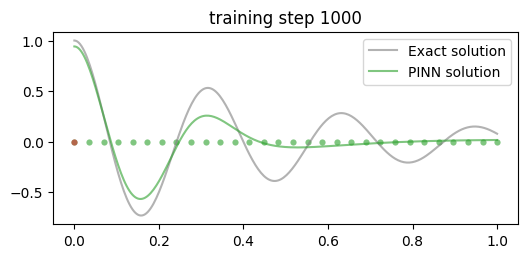

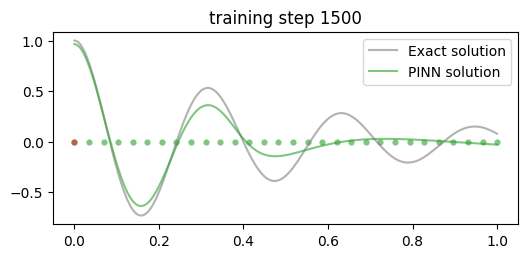

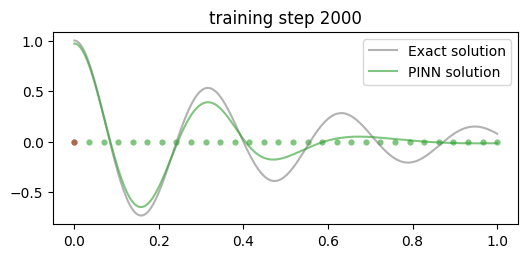

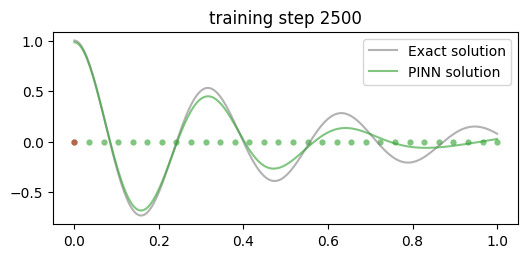

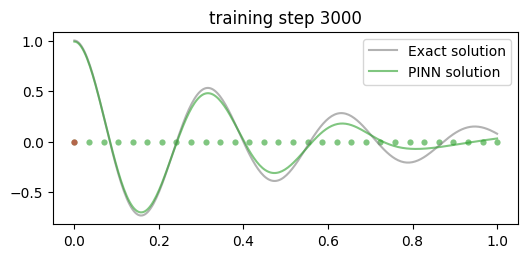

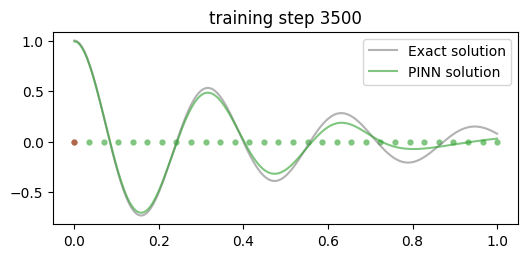

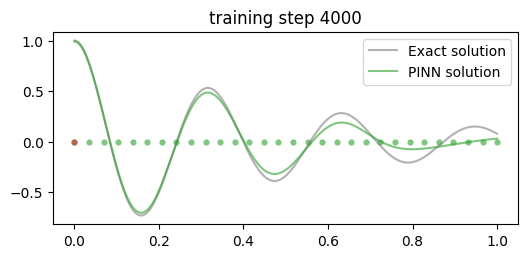

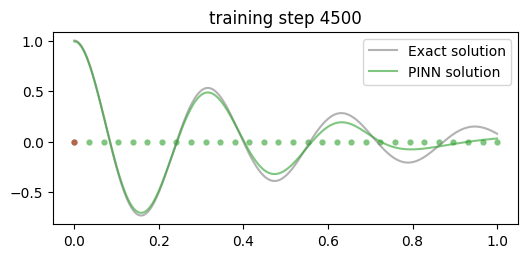

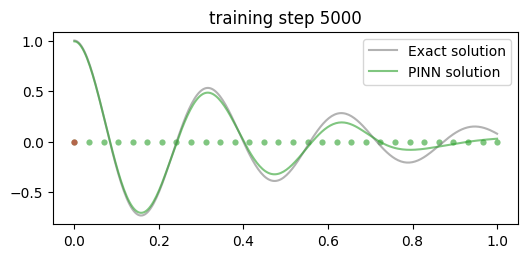

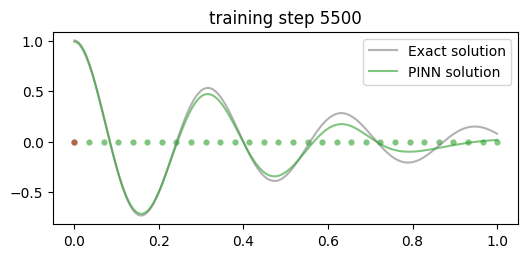

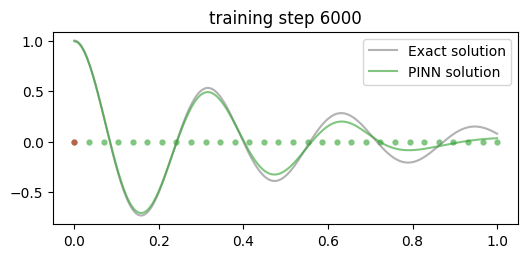

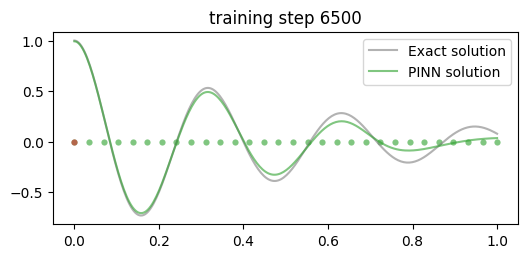

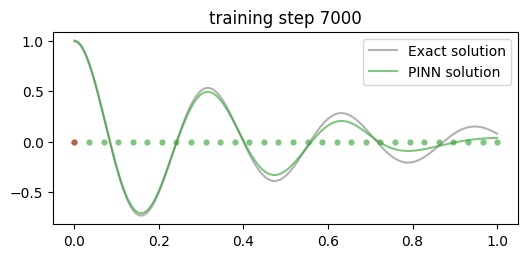

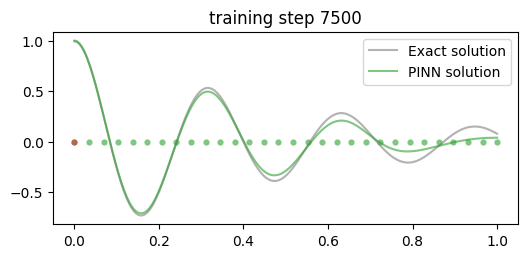

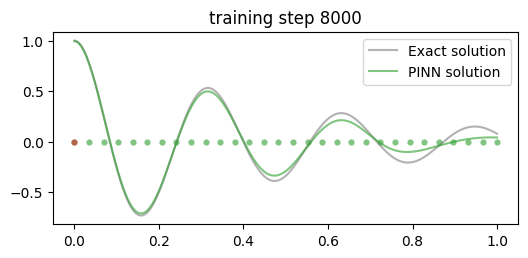

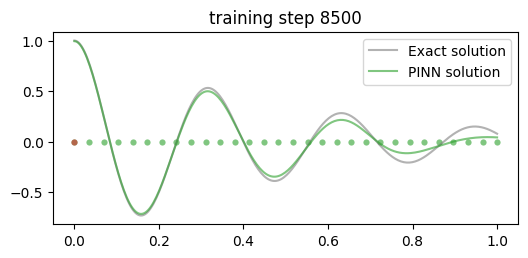

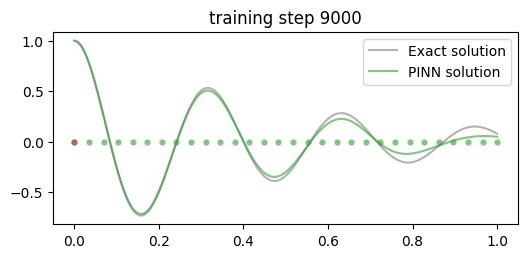

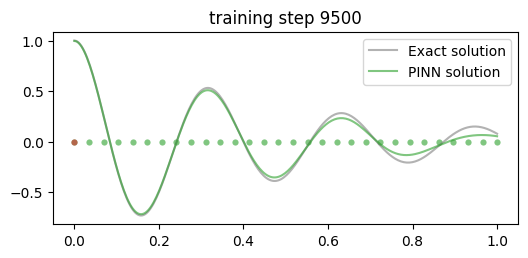

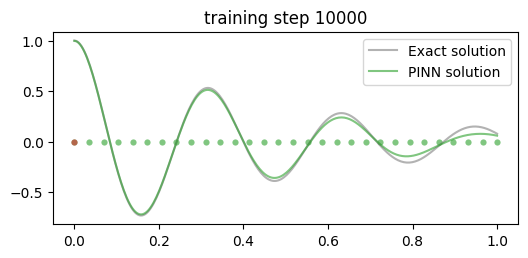

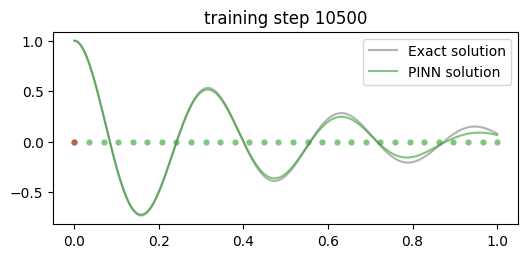

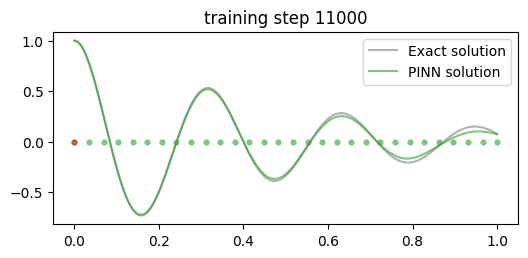

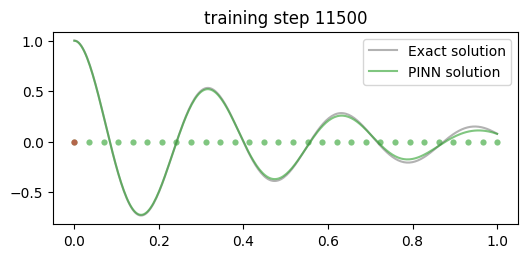

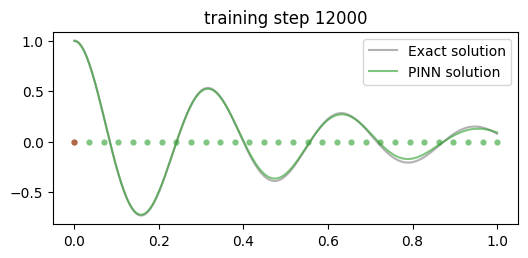

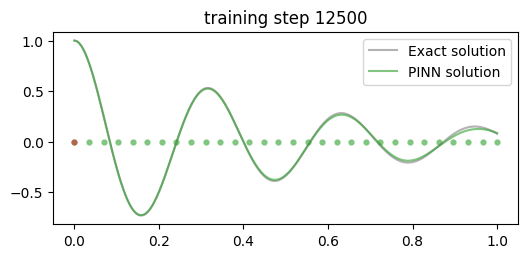

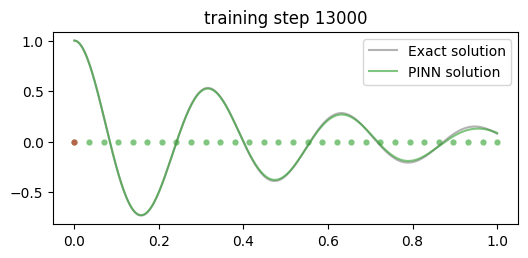

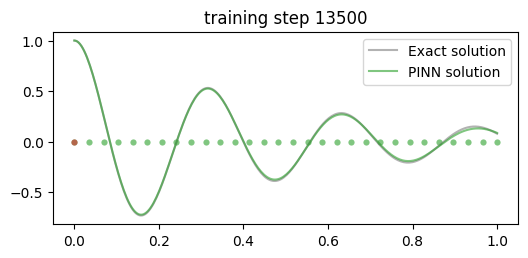

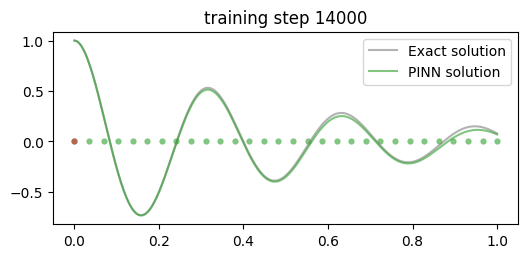

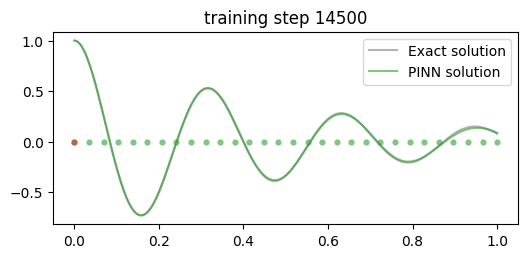

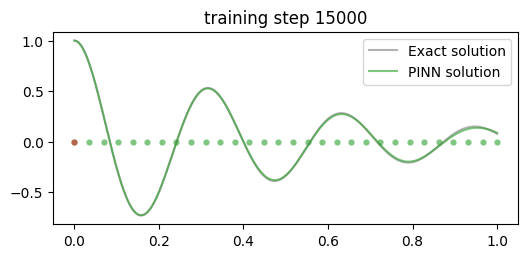

In [ ]:
torch.manual_seed(123)

#Defining a NN based on our earlier class
pinn = FCN(1,1,32,3) #INPUT, OUPUT, HIDDEN, LAYYERS

#parameter view
#for name, param in pinn.named_parameters():
#    print(name, param.shape)

#Define boundary points 
#require_grad to track all operations involving the evaluation points
#Initial / boundary is in t=0
t_boundary = torch.tensor(0., requires_grad=True).view(-1,1)
#domain [0,1]
t_physics = torch.linspace(0,1,30, requires_grad=True).view(-1,1) #collocation points where the equation is solved

#training the PINN
d,w0 =2,20
mu,k =2*d, w0**2
t_test= torch.linspace(0,1,300).view(-1,1) #where the function is tested (batch_size, input dim)
u_exact =exact_solution(d,w0,t_test) 

optimiser= torch.optim.Adam(pinn.parameters(),lr=1e-3)

for i in range(15001):
    optimiser.zero_grad() #initilizes grad
    #loss function
    lambda1, lambda2= 1e-1, 1e-4
    
    #boundary loss
    u= pinn(t_boundary)
    loss1= torch.squeeze((u-1)**2) #error with u(t=0)=1
    #requierement for torch autograd special, same shpae as u
    dudt= torch.autograd.grad(u, t_boundary,torch.ones_like(u), create_graph=True)[0]
    loss2 =torch.squeeze((dudt-0)**2)
    
    # Physics loss, it must be 0, due to the way is framed
    u=pinn(t_physics)
    #requires first and second derivative wrt collocation points
    dudt= torch.autograd.grad(u, t_physics,torch.ones_like(u), create_graph=True)[0]
    dudt2= torch.autograd.grad(dudt, t_physics,torch.ones_like(u), create_graph=True)[0]
    loss3= torch.mean((dudt2+mu*dudt+k*u)**2) #each point is already evaluated in the network this is a tensor
    #lo
    
    #Backpropagation
    loss= loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward() # calculate the loss gradient wrt to each parameter, including time points
    optimiser.step()
    
    #plot the result as training progresses
    if i%500==0:
        u= pinn(t_test).detach() #forward pass with surrogate
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color ="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color ="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha= 0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green", alpha= 0.6)
        plt.title(f"training step {i}")
        plt.legend()
        plt.show()
        

## Inverse problem

In this case the PINN is trained directly to approximate the solution of the ODE, but we now assume that one of the parameters, $\mu$ is not known and we treat it as an additional learnable parameter when training the PINN.

In the inverse problem we know have observed data on $u(t)$. The loss function is:

$$\mathcal{L}(\theta)=\frac{1}{N} \sum_i^N\left(\left[m \frac{d^2}{d t^2}+\mu \frac{d}{d t}+k\right] N N\left(t_i ; \theta\right)\right)^2 +\frac{\lambda}{M} \sum_i^M\left(N N\left(t_i ; \theta \right) - u_{obs}(t_j) \right)^2  $$


True value of mu:4


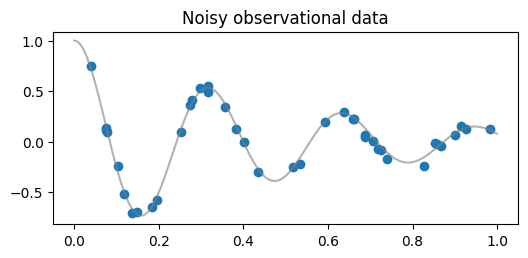

In [6]:
# We create some noisy observation
torch.manual_seed(123)
d, w0 =2,20
print(f"True value of mu:{2*d}")
t_obs= torch.rand(40).view(-1,1) #random sample
u_obs= exact_solution(d,w0,t_obs) + 0.04*torch.randn_like(t_obs) #random observations
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact= exact_solution(d,w0,t_test)

plt.figure(figsize=(6,2.5))
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0])
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.show()


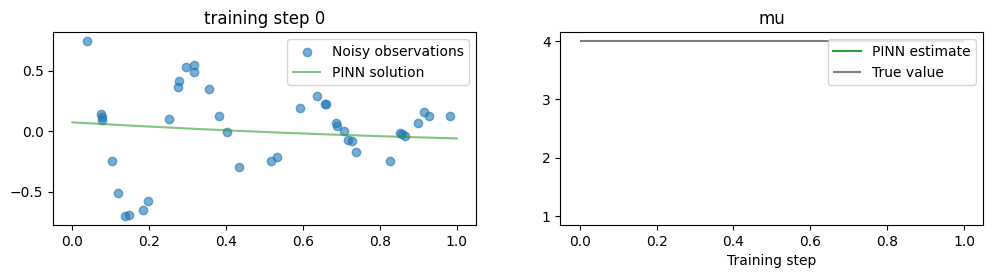

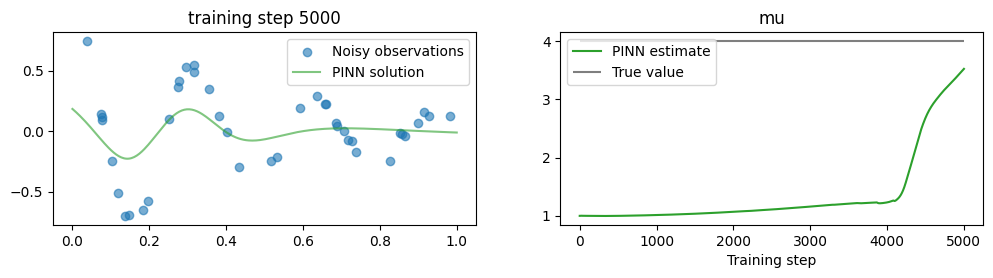

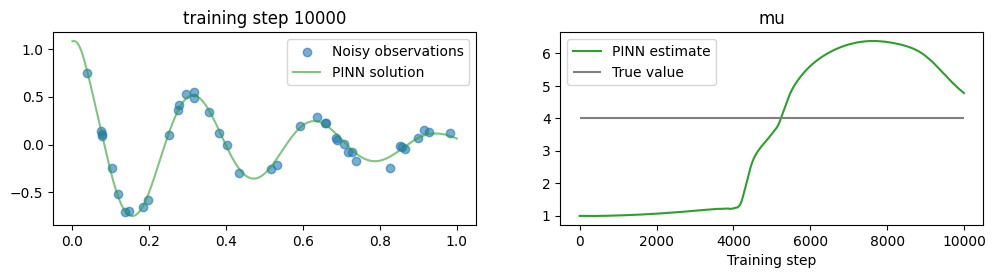

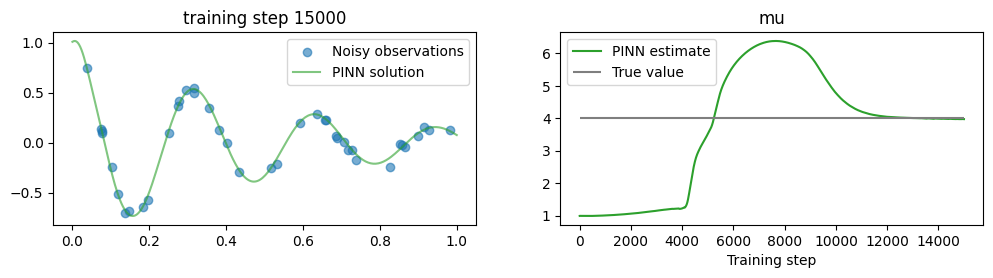

In [ ]:
# New procedure for inverse problem
torch.manual_seed(123)

pinn = FCN(1,1,32,3) #INPUT, OUPUT, HIDDEN, LAYYERS

#domain [0,1]
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True) #collocation points where the equation is solved

#training the PINN
d,w0 =2,20
_,k =2*d, w0**2
t_test= torch.linspace(0,1,300).view(-1,1) #where the function is tested (batch_size, input dim)
u_exact =exact_solution(d,w0,t_test) 

#add mu as a learnable parameter
mu = torch.nn.Parameter(torch.tensor(1., requires_grad=True)) #initial value as parameter so it can learn
#list comprehension to feed to parameters and mu
optimiser= torch.optim.Adam(list(pinn.parameters())+[mu],lr=1e-3)
mus=[]

for i in range(15001):
    optimiser.zero_grad() #initilizes grad, same optimizer as before
    #loss function
    lambda1=1e4 #larguer lambda
    
    #boundary loss
    u= pinn(t_physics)
    
    dudt= torch.autograd.grad(u, t_physics,torch.ones_like(u), create_graph=True)[0]
    du2dt2= torch.autograd.grad(dudt, t_physics,torch.ones_like(dudt), create_graph=True)[0]
    loss1= torch.mean((du2dt2+ mu*dudt +k*u)**2) #each point is already evaluated in the network this is a tensor
    #Data loss
    u= pinn(t_obs)
    loss2= torch.mean((u-u_obs)**2)
    
    #Backpropagation
    loss= loss1 + lambda1*loss2 
    loss.backward() # calculate the loss gradient wrt to each parameter, including time points
    optimiser.step()
    
    mus.append(mu.item()) #get numerical value of mu to save
    
    #plot the result as training progresses
    if i%5000==0:
        u= pinn(t_test).detach() #forward pass with surrogate
        plt.figure(figsize=(12,2.5))
        
        plt.subplot(1,2,1)
        plt.scatter(t_obs[:,0], u_obs[:,0], label="Noisy observations", color="tab:blue", alpha= 0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green", alpha= 0.6)
        plt.title(f"training step {i}")
        plt.legend()
        
        plt.subplot(1,2,2)
        plt.title("mu")
        plt.plot(mus, label="PINN estimate", color="tab:green")
        plt.hlines(2*d,0,len(mus), label ="True value", color= "tab:grey")
        plt.xlabel("Training step")
        plt.legend()
        plt.show()
        